<h1 style="text-align:center">New York City Taxi Trip Duration</h1>

<h3>Load Libraries</h3>

In [1]:
import numpy as np
import pandas as pd

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h3>Load Dataset</h3>

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (1458644, 11)
Test set shape: (625134, 9)


<h3>Data exploration</h3>

In [5]:
# Observation of the first 5 elements in the training set
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
# Check the types or each features
train_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Analyze missing data 

In [7]:
print(train_df.isnull().sum(), "\n")
print(test_df.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64 

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


There's no missing data in both the train and test dataframe

<u>Target Feature</u>

In [8]:
pd.options.display.float_format = '{:,.2f}'.format
train_df['trip_duration'].describe()

count   1,458,644.00
mean          959.49
std         5,237.43
min             1.00
25%           397.00
50%           662.00
75%         1,075.00
max     3,526,282.00
Name: trip_duration, dtype: float64

Let's observe the skewness of the trip duration

In [9]:
train_df['trip_duration'].skew()

343.1639435917362

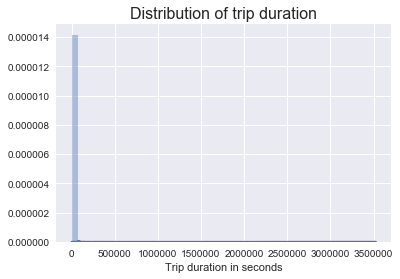

In [10]:
sns.distplot(train_df['trip_duration'])
plt.title("Distribution of trip duration", size=16)
plt.xlabel("Trip duration in seconds")
plt.show()

In regression problems, it is important to look for the skewness of the target feature. <br>
In fact, algorithms such as linear regression or K-Nearest Neighbors are sensitive to the skewness of the data. <br>
The most common correction for a positive skew is to apply <i>the Log transform</i> to have a normally distributed variable.

Skew is: -0.340704230448


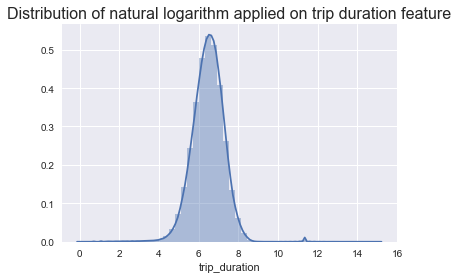

In [11]:
target = np.log(train_df['trip_duration'])
print("Skew is:", target.skew())
sns.distplot(target)
plt.title("Distribution of natural logarithm applied on trip duration feature", size=16)
plt.show()

For the sake of meaningful visualization, we store the result in another variable so that we will be able to make use of it during the processing part.

<u>Correlation with trip duration</u>

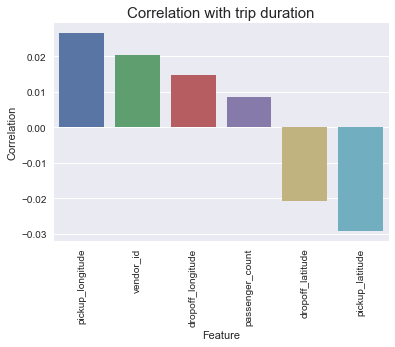

In [12]:
corr = train_df.drop(['id'], axis=1).corr()
corr_df = pd.DataFrame(corr['trip_duration'].sort_values(ascending=False))[1:]
corr_df.columns = ['Correlation']
corr_df.index.name = 'Feature'

ax = sns.barplot(x=corr_df.index, y='Correlation', data=corr_df)
ax.set(ylabel='Correlation')
plt.xticks(rotation=90)
plt.title('Correlation with trip duration', size=15)
plt.show()

We observe that there is not strong relation with the trip duration and the actual numerical features. <br>
We need to feature engineering the string features to establish a new correlation plot as we might infer something more interesting.

<h3>Feature Engineering</h3>

In [13]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,435


In [15]:
# convert feature to datetime
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], \
                    format="%Y-%m-%d %H:%M:%S") 

# Extract weekday number (from Monday=0 to Sunday=6)
train_df['DayOfWeekNum'] = train_df['pickup_datetime'].dt.dayofweek

# Extract Day of week
train_df['DayOfWeek'] = train_df['pickup_datetime'].dt.weekday_name

# Extract Month 
train_df['Month'] = train_df['pickup_datetime'].dt.month

# Extract the Month's day from 0 to 31
train_df['DayOfMonth'] = train_df['pickup_datetime'].dt.day

# Extract the Hour of the day
train_df['HourOfDay'] = train_df['pickup_datetime'].dt.hour


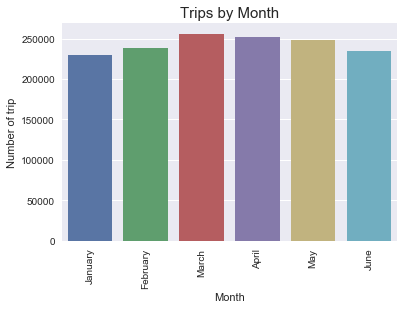

In [16]:
fig, ax = plt.subplots()

sns.countplot(x='Month', 
             data=train_df)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['January', 'February', 'March', 'April', 'May', 'June']

ax.set_xticklabels(labels)

plt.xticks(rotation=90)
plt.title('Trips by Month', size=15)
plt.ylabel('Number of trip')

plt.show()

Interestingly, the data provided only offers the trips of the first half of 2016. <br>
Furthermore, we observe that March was the most successful month in terms of number of trips. <br>
On the other hand January is not as successful, probably due to the fact that January is usually the coldest month of the year for New York.

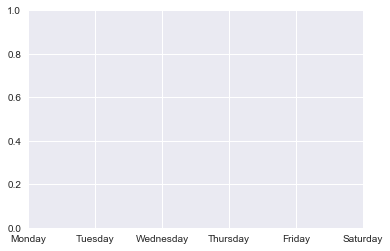

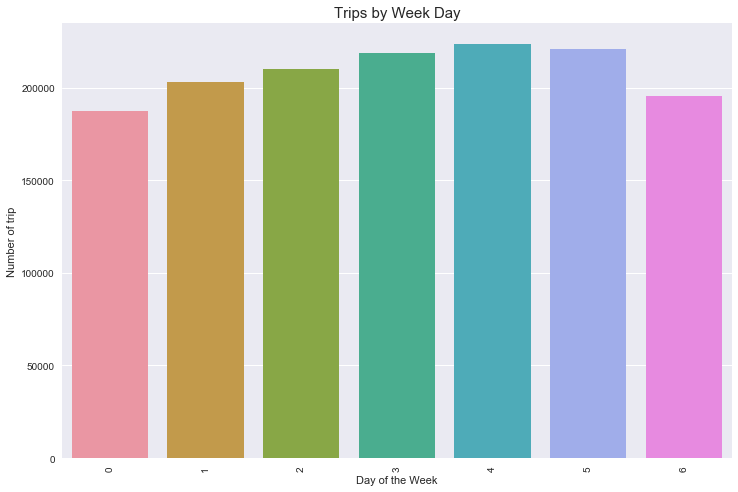

In [28]:
fig, ax = plt.subplots()


sns.countplot(x='DayOfWeekNum',
              data=train_df)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', \
         'Friday', 'Saturday', 'Sunday']

ax.set_xticklabels(labels)

plt.xticks(rotation=90)
plt.title('Trips by Week Day', size=15)
plt.xlabel('Day of the Week')
plt.ylabel('Number of trip')


plt.show()

This previous plot display how the traffic of taxis is doing during the weeks. <br>
Friday seems to be the most profitable day with Saturday while Sunday and Monday are the less demanding of taxis.

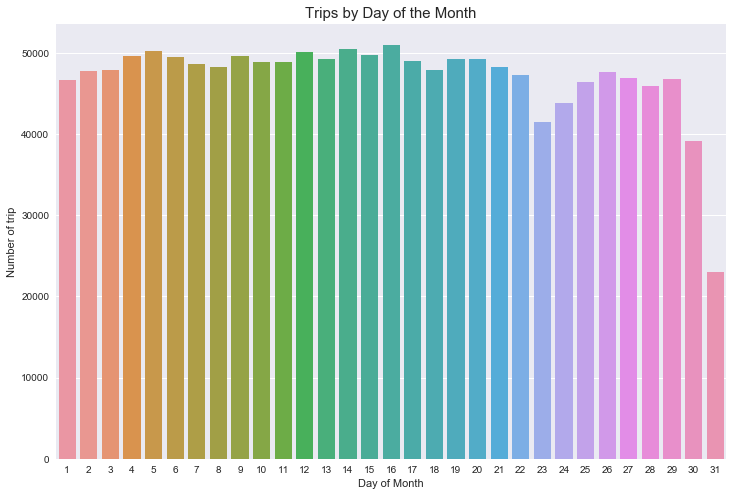

In [32]:
plt.figure(figsize=(12,8))

sns.countplot(x='DayOfMonth',
             data=train_df)

plt.title('Trips by Day of the Month', size=15)
plt.xlabel('Day of Month')
plt.ylabel('Number of trip')

The repartition is quite well distributed. <br>
One might notice that the 31st there is way less trips but that is due to the fact there is way less 31st number in the year. <br>
In 2016, only January, March and May had 31 days in the first half of the year. <br>
Days with 31 days also include day 30 so end of months are quite low regarding number of trips from taxis comparing to other days.